In [1]:
# viewing neural data
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.signal import hilbert
from scipy.stats import pearsonr
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5

matplotlib.style.use('ggplot')


# Check wihic computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name
if  comp_name == 'chim':
    #sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join(os.path.abspath('W:') , "earneodo", "bci_zf")
elif  'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/reposs')
    experiment_folder = os.path.join(os.path.abspath('/Volumes') , 'gentner', 'earneodo', 'bci_zf')

elif 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

elif 'passaro' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

import soundtools as st
import Kwik as oe


raw_data_folder = os.path.join(experiment_folder, 'raw_data')
ss_data_folder = os.path.join(experiment_folder, 'ss_data')


#given a chunk that contains a sine wave, find its onset
def peaks(signal, min_height=0):
    np.where(signal[1:-1]>min_height)
    peak_ind = [i for i in np.where(signal[1:-1]>min_height)[0] if signal[i]>signal[i-1] & signal[i]>signal[i+1]]
    return peak_ind

def find_onset_sine(chunk, freq=1000, f_s=30000):
    roof = int(max(chunk)*0.25)
    first_peak = peaks(chunk, min_height=roof)[0]
    
    onset = first_peak - int(f_s/(4.*freq))
    return onset

def envelope(x, window=200):
    analytic_signal = hilbert(x)
    amplitude_envelope = np.abs(analytic_signal)
    w=np.ones(window, 'd')
    return np.convolve(w/w.sum(),amplitude_envelope,mode='valid')

def correlation_with_pattern(data, pattern, window, filter_func, *args, **kwargs):
    segment = envelope(filter_func(data, *args, **kwargs), window=window)
    return pearsonr(segment, pattern)[0]

def apply_repeated(s, starts, window, scalar_func, *args, **kwargs):
    # starts, window in sample units
    y = np.empty_like(starts)
    for i_s, start in enumerate(starts):
        a_chunk = st.Chunk(s, segment=[start, start + window])
        y[i_s] = scalar_func(a_chunk.data, *args, **kwargs)

    return y

def band_pass_filter(x, hp_b, hp_a, lp_b, lp_a):    
    x_hi = sg.filtfilt(hp_b, hp_a, x, axis=0)
    x_filt = sg.filtfilt(lp_b, lp_a, x_hi, axis=0)
    return x_filt

def compare_spectrogram(sxx, pattern_sxx):
    return np.sum(np.abs(pattern_sxx-sxx)/np.sum(np.abs(sxx)))

def spectral_score(chunk, pattern_sxx):
    f, t, Sxx = spectrogram(chunk.data, chunk.sound.s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
    assert(Sxx.shape == pattern_sxx.shape)
    return compare_spectrogram(Sxx, pattern_sxx)


Computer: passaro


In [2]:
#file structure
bird_id = 'z020'
sess = 'day-2016-06-02'
rec = 0
run = 1
processor = ''

raw_file_folder = os.path.join(ss_data_folder, bird_id, sess)
raw_file_base_name = 'experiment'

raw_file_name = raw_file_base_name + processor + '.raw.kwd'
evt_file_name = raw_file_base_name + '.kwe'

raw_file_path = os.path.join(raw_file_folder, raw_file_name)
#evt_file_path = os.path.join(raw_file_folder, evt_file_name)

# open the file in read mode
raw_file = h5py.File(raw_file_path, 'r')
#evt_file = h5py.File(evt_file_path, 'r')

# load it with the open-ephys api for version 2 of kiwk format

oe_file = oe.load(raw_file_path)


In [3]:
# list records
raw_file['recordings'].keys()

[u'0', u'1', u'2', u'3', u'4', u'5']

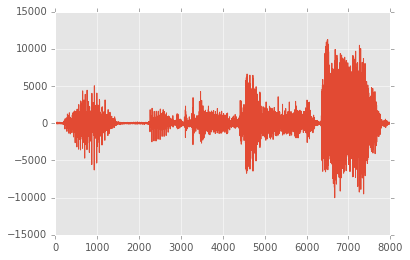

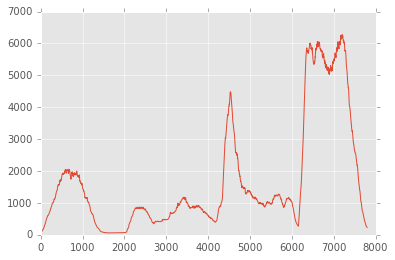

In [6]:
# get the sound and the pattern
chan_name = "CH17"
chan_number = 16
data_table = raw_file['/recordings'][str(rec)]['data']
chan_sf = oe.get_sample_rate(raw_file)
pattern = 1
#filter parameters
filt_lo = 10000 #Hz
filt_hi = 500 #Hz

# sonogram parameters
n_window = 256;
n_overlap = 192;
f_cut = 10000;
sigma = 1./1000.*chan_sf

audio_slice = h5.load_table_slice(data_table, np.arange(0, data_table.shape[0]), [chan_number])
chan_sound = st.DatSound(audio_slice[:,0], chan_sf, data_type=np.float)
# # Now try to save a channel as a wav file
# from scipy.io import wavfile
# out_file_name = raw_file_base_name +  '_' + chan_name + 'song.wav'
# wavfile.write(os.path.join(raw_file_folder, out_file_name),chan_sf, np.array(chan_sound.stream, dtype='int16'))

#make the filter for the data file
s_f = chan_sound.s_f
#The band where we expect most of the energy of zf song to be in
hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')

# read a bout from a wave file and prepare the templates 
pattern_name = 'pattern_' + str(pattern) + '.wav'
pattern_path = os.path.join(raw_file_folder, pattern_name)

pattern_sound = st.WavData2(pattern_path)
pattern_chunk = st.Chunk(pattern_sound)
pattern_chunk.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)
plt.plot((pattern_chunk.data))
pattern_envelope = envelope(pattern_chunk.data[:,0])
plt.figure()
plt.plot(pattern_envelope)
pattern_spectrogram = spectrogram(pattern_chunk.data[:,0], s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
plt.figure()


In [7]:
# try to get the template matches from soundtools functions
import threading
from IPython.display import display

class chunkFunction():
    def __init__(self, chunk, function, *args, **kwargs):
        print args
        self.chunk = chunk
        self.func = function
        self.args = args
        self.kwargs = kwargs

    def start(self):
        display('Starting function {0}'.format(self.func.func_name))
        for arg in self.args:
            print arg
        for key, arg in self.kwargs.iteritems():
            print key
            print arg
        self.chunk.apply_filter(self.func, *self.args, **self.kwargs)
        print "done"

class threadFunction():
    def __init__(self, function, *args, **kwargs):
        self.func = function
        self.args = args
        self.kwargs = kwargs
        self.out = None

    def run(self):
        display('Starting function {0}'.format(self.func.func_name))
        for arg in self.args:
            print arg
        for key, arg in self.kwargs.iteritems():
            print key
            print arg
        self.out = self.func(*self.args, **self.kwargs)
        print "done"

In [8]:
st.envelope(pattern_chunk.data[:,0]).shape

(7501,)

In [9]:
task_match_by_envelope = threadFunction(st.match_by_envelope, 
                                        chan_sound, pattern_chunk, 
                                        window_size=200)

threads = []
t = threading.Thread(name= 'match_envelope', 
                     target=task_match_by_envelope.run)
threads.append(t)
t.start()

'Starting function match_by_envelope'

<soundtools.DatSound instance at 0x7f28512a2d88>
<soundtools.Chunk instance at 0x7f28512a2f80>
window_size
200


In [69]:
t.isAlive()

True

In [58]:
def get_chunk(datsound, start, end, chan_list=[0]):
    assert (start >= 0)
    assert (end <= datsound.n_samples)
    assert (end > start)

    if datsound.stream.shape[0] == datsound.stream.size:
        data = datsound.stream[start:end]
    else:
        data = datsound.stream[start:end, chan_list]
    
    print data.shape
    print datsound.stream.shape[0]

    return np.array(data, dtype=np.dtype(datsound.data_type)).reshape([data.shape[0], len(chan_list)])


In [65]:
from soundtools import DatSound

chan_sound2 = DatSound(audio_slice[:,0], chan_sf, data_type=np.float)

a_chunk = chan_sound2.get_chunk(0, 8000)

ValueError: total size of new array must be unchanged

In [29]:
candidate_starts = [0, 16000, int(3674.214226*30000.)]

chan_sound.apply_repeated(candidate_starts, pattern_chunk.samples, 
                         spectrogram_diff, pattern_spectrogram[2])

ValueError: total size of new array must be unchanged

In [25]:
# that should leave a bunch of match candidates.
# we want to go through them and get their spectogram diff to the template's one.
def compare_spectrogram(sxx, pattern_sxx):
    return np.sum(np.abs(pattern_sxx-sxx)/np.sum(np.abs(sxx)))

def spectrogram_diff(data, pattern_sxx):
    f, t, Sxx = spectrogram(data[:,0], s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
    assert(Sxx.shape == pattern_sxx.shape)
    return compare_spectrogram(Sxx, pattern_sxx)

def spectral_score(chunk, pattern_sxx):
    f, t, Sxx = spectrogram(chunk.data, chunk.sound.s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
    assert(Sxx.shape == pattern_sxx.shape)
    return compare_spectrogram(Sxx, pattern_sxx)

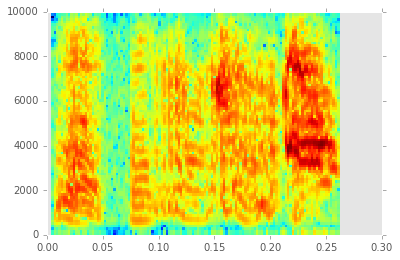

In [35]:
ch

f, t, sxx_pattern = spectrogram(pattern_chunk.data[:,0], s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')

plt.pcolormesh(t, f[f<f_cut], np.log(sxx_pattern[f<f_cut, :]))

In [48]:
pattern_chunk.apply_filter(envelope)

ValueError: object too deep for desired array

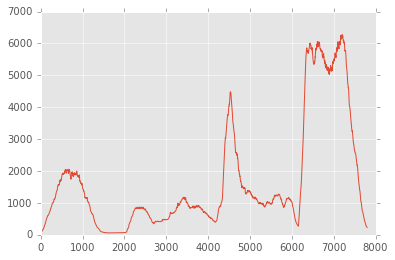

In [38]:
plt.plot(envelope(pattern_chunk.data[:,0]))

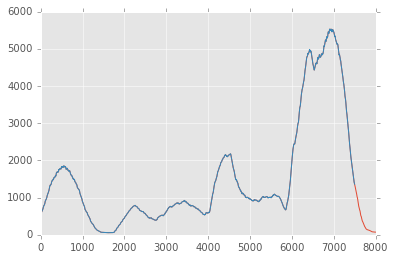

In [66]:
plt.plot(full_chunk.data[bout.start:bout.end])
plt.plot(bout.data)

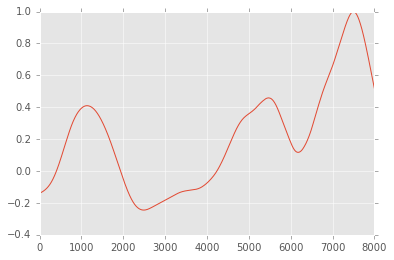

In [106]:
plt.plot(task_find_template.out['corr'][bout.start: bout.end])

In [ ]:
corr_thresh = 0.91
max_pos = np.where((a>0) & (b>0) & (c>corr_thresh))[0]
rc.values[max_pos]
one_max = 0
max_pos[one_max]

all_Sxx = []
for one_max in max_pos:
    motif_start = one_max - bout.data.size + window_size
    motif_end = motif_start + bout.data.size
    env_max = pd.DataFrame(full_chunk.data[motif_start: motif_end])
    env_max.plot()
    stream_chunk = st.Chunk(chan_sound, segment=[motif_start, motif_end])
    stream_chunk.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)
   
    f, t, Sxx = spectrogram(stream_chunk.data, s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
    plt.figure()
    plt.pcolormesh(t, f[f<f_cut], np.log(Sxx[f<f_cut, :]))
    all_Sxx.append(np.log(Sxx))

0.45244448447897434

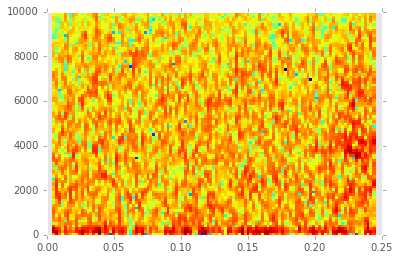

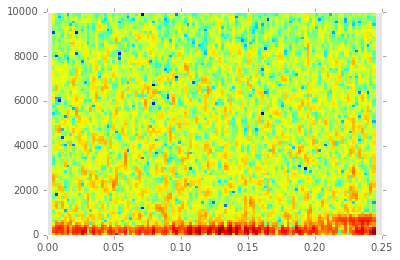

In [265]:
i = 21
plt.pcolormesh(t, f[f<f_cut], (all_Sxx[i][f<f_cut, :]))
plt.figure()
plt.pcolormesh(t, f[f<f_cut], (all_Sxx[7][f<f_cut, :]))
np.sum(np.abs(all_Sxx[i]-all_Sxx[7]))/np.sum(np.abs(all_Sxx[2]))

In [175]:
norm_sad = np.array([np.sum(np.abs(one_sxx-all_Sxx[7]))/np.sum(np.abs(all_Sxx[7])) for one_sxx in all_Sxx])

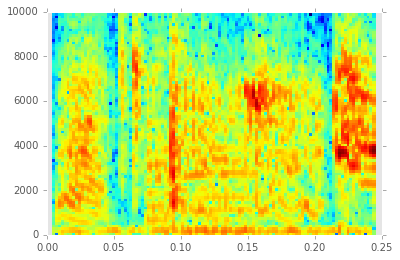

In [269]:
f, t, pattern_Sxx = spectrogram(chan_sound.stream[bout2_start: bout2_start+bout.data.size], s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
plt.pcolormesh(t, f[f<f_cut], np.log(pattern_Sxx[f<f_cut, :]))

In [188]:
env1 = pd.DataFrame(full_envelope[bout_start-300:bout_end+3000])
env2 = pd.DataFrame(full_envelope[bout2_start-3000:bout2_end+3000])

In [76]:
corr_thresh = 0.91
max_pos = np.where((a>0) & (b>0) & (c>corr_thresh))[0]
rc.values[max_pos]
one_max = 0
max_pos[one_max]

for one_max in max_pos:
    motif_start = one_max - pattern.size + window
    motif_end = motif_start + pattern.size                           
    env_max = pd.DataFrame(full_envelope[motif_start: motif_end])
    env_max.plot()
    f, t, Sxx = spectrogram(chan_sound.stream[motif_start-window: motif_end-window], s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
    plt.figure()
    plt.pcolormesh(t, f[f<f_cut], np.log(Sxx[f<f_cut, :]))

NameError: name 'pattern' is not defined

In [286]:
max_pos = max_pos[np.argsort(rc.values[max_pos], axis=0)]

In [362]:
manual_starts = [3674.214226,
                 5440.417182,
                 5440.931701,
                 5441.436431,
                 5441.937063,
                 5442.929469,
                 5444.768863,
                 3677.666521]
manual_starts = np.array(np.array(manual_starts)*s_f, dtype=np.int) + pattern.size
manual_starts

array([110240528, 163226617, 163242053, 163257194, 163272213, 163301986,
       163357167, 110344097])

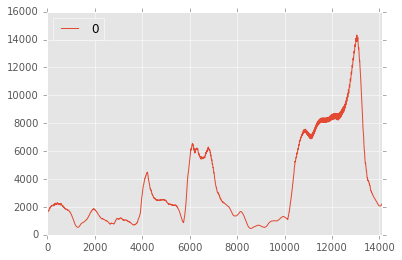

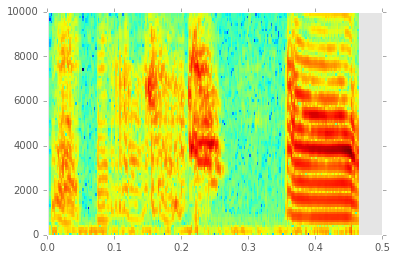

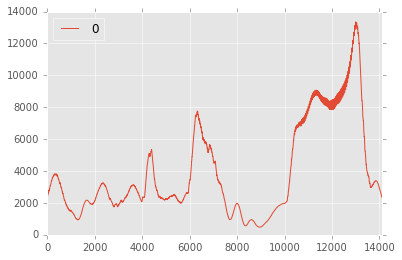

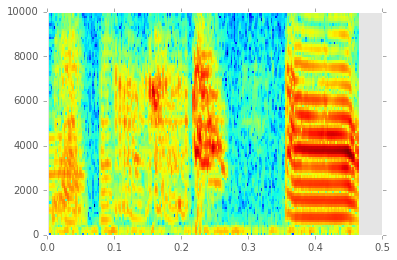

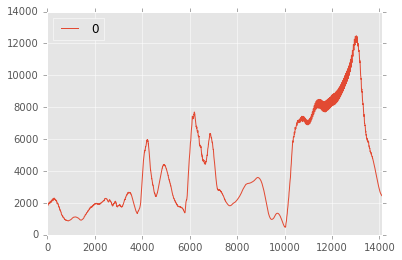

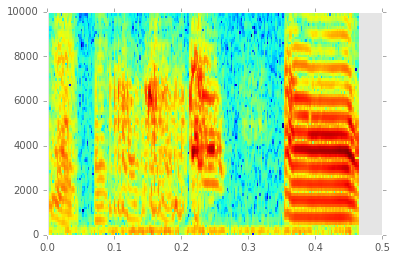

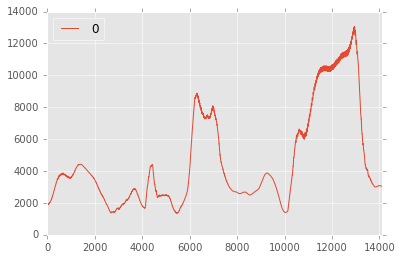

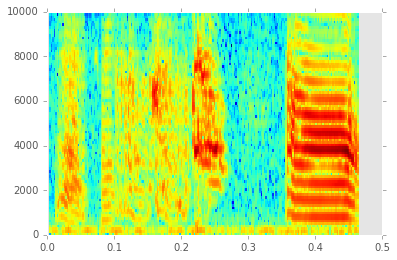

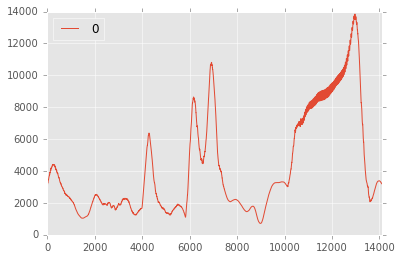

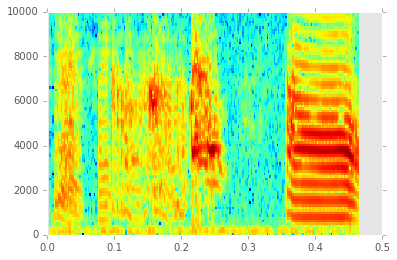

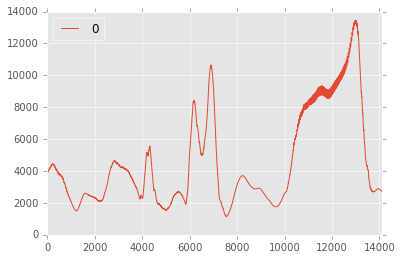

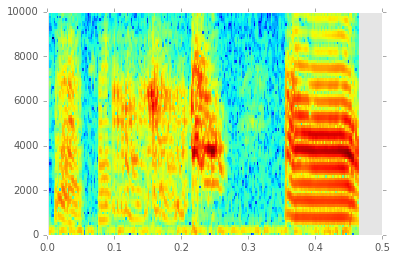

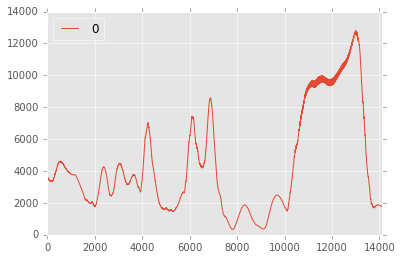

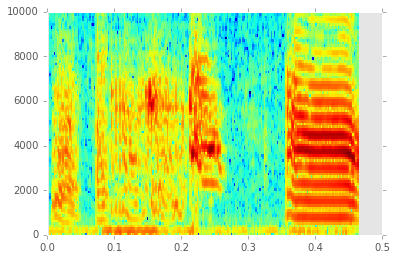

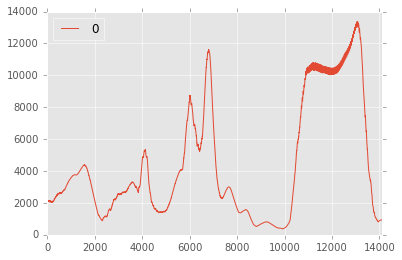

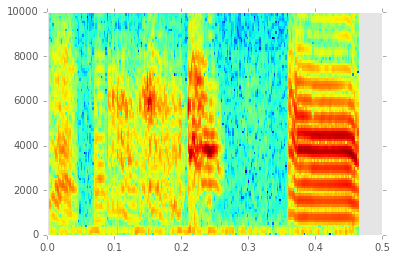

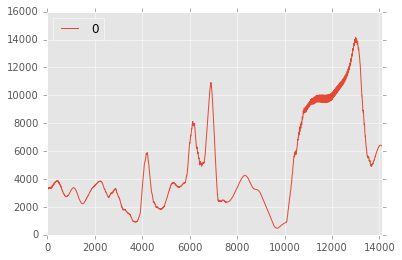

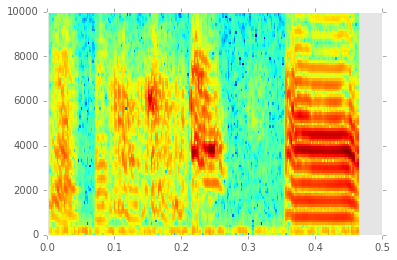

In [371]:
one_max = 0
max_pos[one_max]

for one_max in max_pos:
    motif_start = one_max - pattern.size + window
    motif_end = motif_start + pattern.size                           
    env_max = pd.DataFrame(full_envelope[motif_start: motif_end])
    env_max.plot()
    f, t, Sxx = spectrogram(chan_sound.stream[motif_start-window: motif_end-window], s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
    plt.figure()
    plt.pcolormesh(t, f[f<f_cut], np.log(Sxx[f<f_cut, :]))
    